In [1]:
from collections import Counter, defaultdict

## A basic n-gram generator
Using the tokenizer written in Assignment 3

In [2]:
def new_reg_tokenize(sent):
    fin = re.findall(r'[\U00010000-\U0010ffff]'\
                     r'|[A-Z0-9a-z]+[A-Z0-9a-z._%+-]*@[A-Z0-9a-z]+(?:\.[A-Z0-9a-z]+)+'\
                     r'|(?<= )[$€£¥₹]?[0-9]+(?:[,.][0-9]+)*[$€£¥₹]?'\
                     r'|(?:(?:https?:\/\/(?:www.)?)|www.)[A-Z0-9a-z_-]+(?:\.[A-Z0-9a-z_\/-]+)+'\
                     r'|(?:(?<=[^A-Za-z0-9])|^)@[A-Z0-9a-z._+]+[A-Za-z0-9_]'\
                     r'|#[A-Za-z0-9]+(?:[\._-][A-Za-z0-9]+)*'\
                     r'|\.{3,}'\
                     r'|[!"#$%\&\'()*+,\-.:;<=>?@\[\\\/\]\^_`{\|}~]'\
                     r'|[A-Z]\.'\
                     r'|\w+', sent)
    return fin

In [3]:
import re
# from nltk.tokenize import word_tokenize

def ngrams(sentence, n):
    '''
    This currently does not accomodate for numbers with punctuation.
    '''
#     sentence = sentence.lower()
    
    tokens = new_reg_tokenize(sentence)
    
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [ngram for ngram in ngrams]

# Creating the Model

Outputs we get from this:
1. `cn` stores the number of n-grams for each n, n=1-n
2. `model` stores the counts of each n-gram
3. `incv` stores the various contexts of the n'th gram, with counts
4. `invc` stores the count of number of contexts for the n'th gram


In [4]:

def create_model(file="../corpus3.txt", n=3):
    '''
    Takes a file to train on, an 'n'
    Returns predictive n-gram model
    '''
    cn = defaultdict(lambda: 0)
    # Create a placeholder for model
    model = defaultdict(lambda: defaultdict(lambda: 0))
    incv = defaultdict(lambda: defaultdict(lambda: 0))
    invc = defaultdict(lambda: defaultdict(lambda: 0))

    with open(file, 'r') as f:
        linet = f.read()
    
#         for line in f:
        for i in range(1, n+1):
            for ngram in ngrams(linet, n=i):
                cn[i] += 1
                wprec = tuple(ngram[:i-1])
                waft = ngram[i-1]
                model[wprec][waft] += 1
                if i >= 2:
                    incv[waft][wprec] += 1
                    if incv[waft][wprec] == 1:
                        invc[waft][len(wprec)] += 1
        f.close()    
            
    return model, incv, invc, cn

In [5]:
%%time
model, incv, invc, cn = create_model(n=3)

CPU times: user 628 ms, sys: 56.2 ms, total: 684 ms
Wall time: 690 ms


In [6]:
model[('this', 'is', )]

defaultdict(<function __main__.create_model.<locals>.<lambda>.<locals>.<lambda>()>,
            {'more': 1,
             'not': 2,
             'known': 1,
             'the': 2,
             'our': 1,
             'a': 1,
             'my': 1,
             '!': 1})

In [7]:
invc['more']

defaultdict(<function __main__.create_model.<locals>.<lambda>.<locals>.<lambda>()>,
            {1: 41, 2: 63})

In [8]:
invc['is']

defaultdict(<function __main__.create_model.<locals>.<lambda>.<locals>.<lambda>()>,
            {1: 504, 2: 793})

# Kneysey-Ney Smoothing

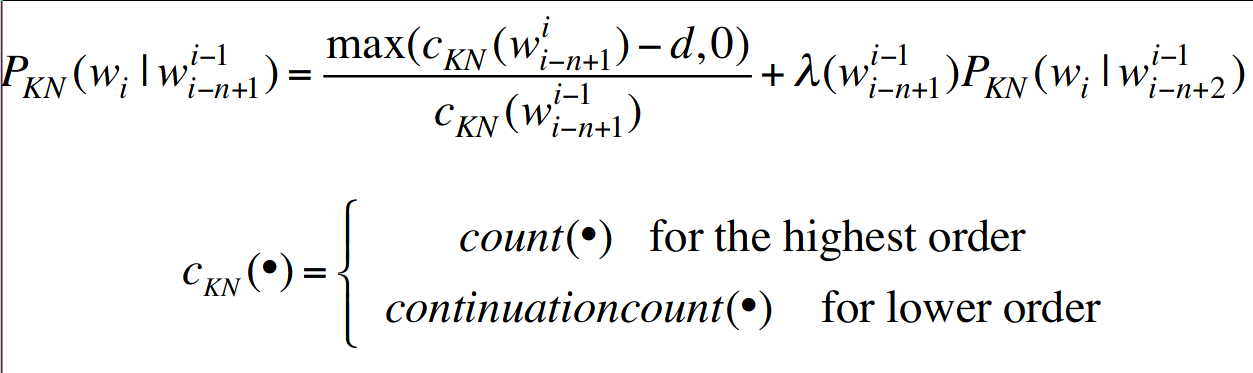

In [9]:
def count_cn(model, invc, seq, pred, first):
#     print(seq, pred, first)
    if first:
        return model[seq][pred]
    else:
        return invc[pred][len(seq)+1]

def lamda(model, cn, seq, pred, d):
#     print(seq, pred, d)
    return d*len(model[seq])/(cn[len(seq)+1])

def kneyser(model, invc, cn, seq, pred, d, first):
#     print(seq, pred)
    if len(seq) == 1:
        return (max(count_cn(model, invc, seq, pred, first) - d, 0)/count_cn(model, invc, seq[:-1], seq[-1], first))+lamda(model, cn, seq, pred, d)*(count_cn(model, invc, seq, pred, first)/len(model[()]))
    else:
        return (max(count_cn(model, invc, seq, pred, first) - d, 0)/count_cn(model, invc, seq[:-1], seq[-1], first))+lamda(model, cn, seq, pred, d)*kneyser(model, invc, cn, seq[1:], pred, d, False)

def kneyser_ney(model, invc, cn):
    smooth = defaultdict(lambda: defaultdict(lambda: 0))
    for seq in model:
        if len(seq) == 0:
            continue
        for pred in model[seq]:
            smooth[seq][pred] = kneyser(model, invc, cn, seq, pred, 0.75, True)
#             print(smooth[seq][pred])
            
    return smooth

smoothed = kneyser_ney(model, invc, cn)

# Calculating Perplexity


In [10]:
import math

def perplexity(smoothed, file='../corpus3.txt', n=2):
    text = ''
    with open(file, 'r') as f:
        text = f.read()
    
    summed = 0
    
    seqs = ngrams(text, n=n)
    for seq in seqs:
        prob = smoothed[seq[:-1]][seq[-1]]
        summed += prob*math.log(prob, 2)

    summed = (summed*-1)/len(seqs)
    return pow(2, summed)


In [12]:
print(perplexity(smoothed, n=3))

1.2715545205935708


In [13]:
invc['love']

defaultdict(<function __main__.create_model.<locals>.<lambda>.<locals>.<lambda>()>,
            {1: 24, 2: 34})

In [14]:
cn

defaultdict(<function __main__.create_model.<locals>.<lambda>()>,
            {1: 82259, 2: 82258, 3: 82257})

# Mechanical work

In [16]:
%%time
model3, incv3, invc3, cn3 = create_model('../corpus3.txt', n=6)
model4, incv4, invc4, cn4 = create_model('../corpus4.txt', n=6)

smoothed3 = kneyser_ney(model3, invc3, cn3)
smoothed4 = kneyser_ney(model4, invc4, cn4)


CPU times: user 5.37 s, sys: 178 ms, total: 5.54 s
Wall time: 5.65 s


In [17]:
perp3 = perplexity(smoothed3, '../corpus3.txt', n=6)
perp4 = perplexity(smoothed4, '../corpus4.txt', n=6)
print(perp3, perp4)

1.4102661014870217 1.41118831317926


In [21]:
smoothed3[('This', 'is', 'the',)]

defaultdict(<function __main__.kneyser_ney.<locals>.<lambda>.<locals>.<lambda>()>,
            {'shop': 0.008930181606652399,
             'widest': 0.008928594769366716,
             'bottle': 0.008928688131725196,
             'same': 0.008931020576644787,
             'girl': 0.008934093141454052,
             'book': 0.04465658990115879,
             'question': 0.008931859546637175,
             'right': 0.008932048208205041,
             'needle': 0.008928688131725196,
             'nearest': 0.00892906093554215,
             'best': 0.044646424702381365,
             'boy': 0.08036844206076281,
             'letter': 0.00893493663076522,
             'house': 0.08036714434919014,
             'man': 0.044656682940708785,
             'ring': 0.008929061258350633,
             'younger': 0.008929061258350633,
             'time': 0.008940724451374045,
             'juggler': 0.008928688131725196,
             'only': 0.008935595009401848,
             'most': 0.008931301632145682

In [18]:
l232 = ('This', 'is', 'the', 'shop', 'where', 'I')
# l232[:-1]

smoothed3[l232[:-1]]

defaultdict(<function __main__.kneyser_ney.<locals>.<lambda>.<locals>.<lambda>()>,
            {'I': 0.25023522901390594})